### Example 3, part A: Diffusion 

In this example we will look at the diffusion equation and how to handle second-order derivatives. For this, we will introduce Devito's `.laplace` short-hand expression and demonstrate it using the examples from step 7 of the original tutorial.

So, the equation we are now trying to implement is

$$\frac{\partial u}{\partial t} = \nu \frac{\partial ^2 u}{\partial x^2} + \nu \frac{\partial ^2 u}{\partial y^2}$$

To discretize this equation we will use central differences and reorganizing the terms yields

\begin{align}
u_{i,j}^{n+1} = u_{i,j}^n &+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n) \\
&+ \frac{\nu \Delta t}{\Delta y^2}(u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n)
\end{align}

As usual, we establish our baseline experiment by re-creating some of the original example runs. So let's start by defining some parameters.

In [1]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 80
ny = 80
nt = 50
nu = .5
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

We now set up the diffusion operator as a separate function, so that we can re-use if for several runs.

In [2]:
def diffuse(u, nt):
    for n in range(nt + 1): 
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1,1:-1] + 
                        nu * dt / dx**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        nu * dt / dy**2 * (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        u[0, :] = 1
        u[-1, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1

Now let's take this for a spin. In the next two cells we run the same diffusion operator for a varying number of timesteps to see our "hat function" dissipate to varying degrees.

Initial state


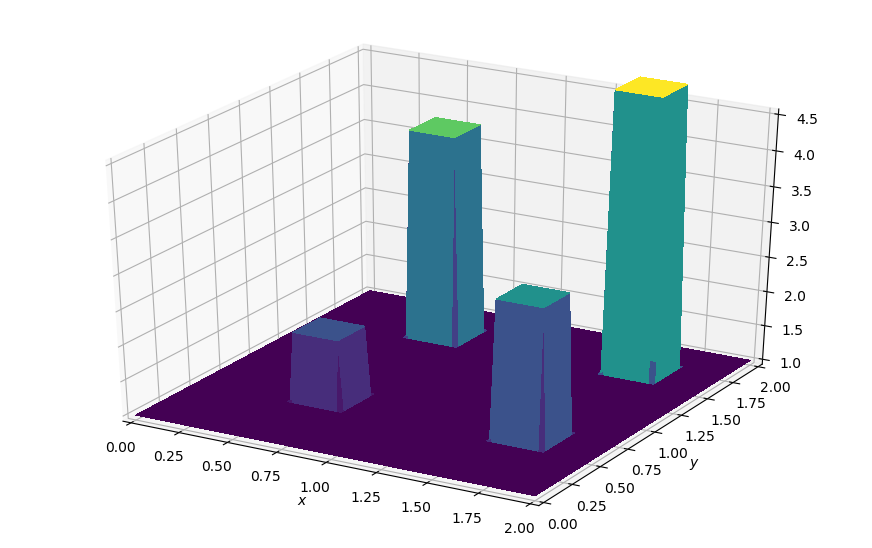

After 50 timesteps


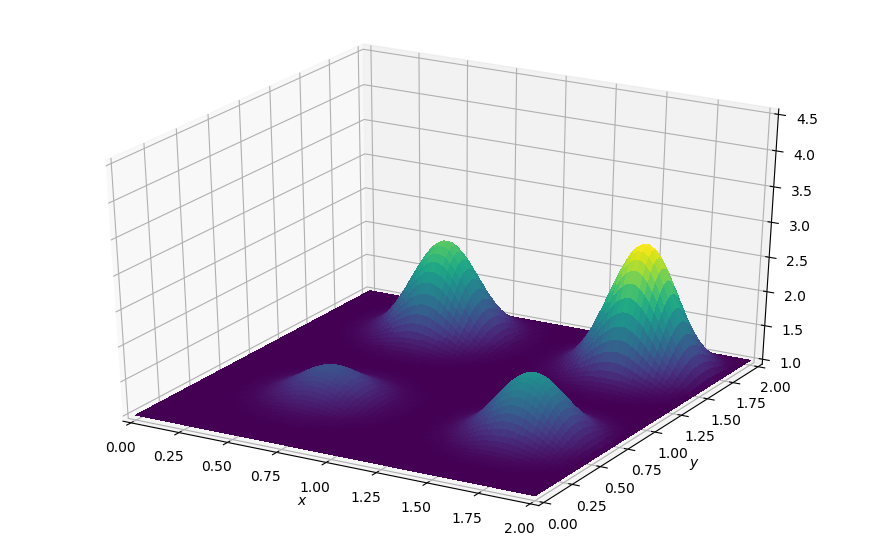

After another 50 timesteps


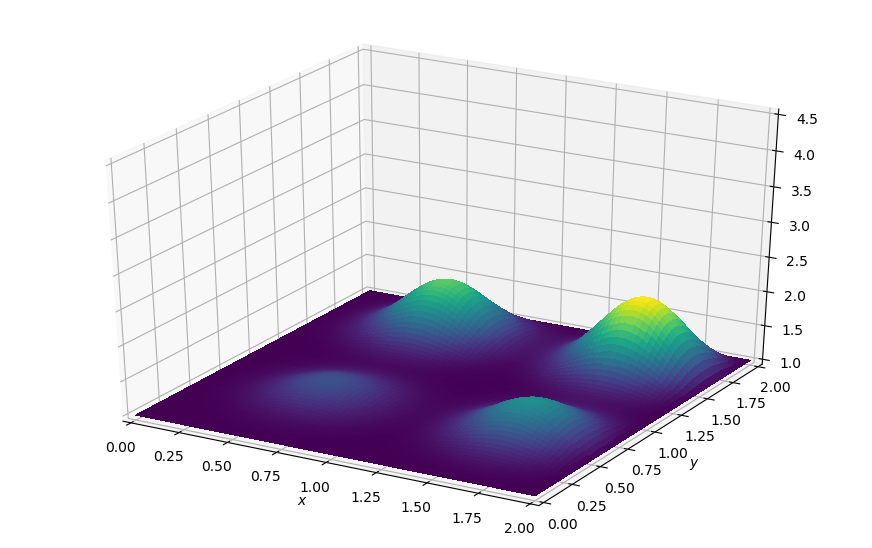

In [3]:
#NBVAL_IGNORE_OUTPUT

# Initialise u with hat function
u = np.empty((nx, ny))
init_hat(field=u, dx=dx, dy=dy, value=1)

# Field initialization
u[ nx//4:nx//4+10 , ny//4:ny//4+10 ] = 2
u[ 3*nx//4:3*nx//4+10 , ny//4:ny//4+10 ] = 3
u[ nx//4:nx//4+10 , 3*ny//4:3*ny//4+10 ] = 4
u[ 3*ny//4:3*ny//4+10 , 3*ny//4:3*ny//4+10 ] = 5

print ("Initial state")
plot_field(u, zmax=4.5)

diffuse(u, nt)
print ("After", nt, "timesteps")
plot_field(u, zmax=4.5)

diffuse(u, nt)
print ("After another", nt, "timesteps")
plot_field(u, zmax=4.5)

After 50 timesteps


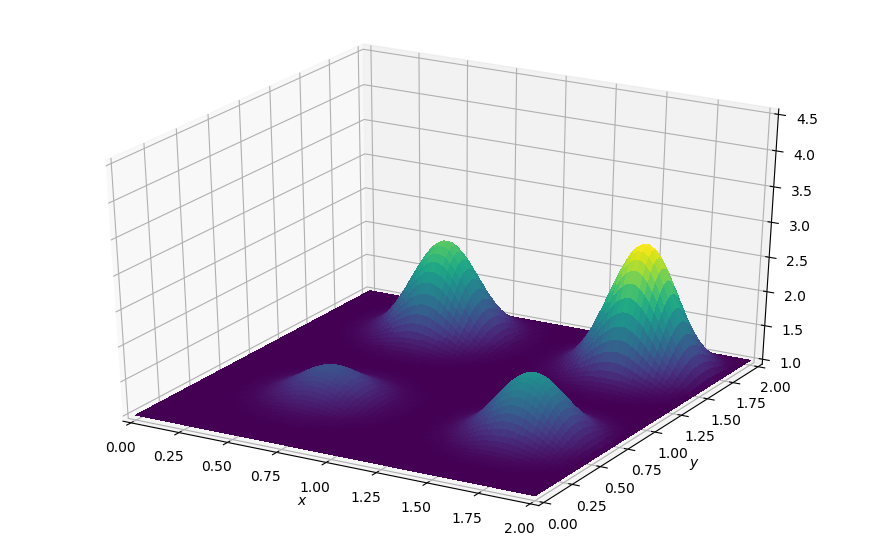

In [4]:
#NBVAL_IGNORE_OUTPUT

# Initialise u with hat function
u = np.empty((nx, ny))
init_hat(field=u, dx=dx, dy=dy, value=1.)

# Field initialization
u[ nx//4:nx//4+10 , ny//4:ny//4+10 ] = 2
u[ 3*nx//4:3*nx//4+10 , ny//4:ny//4+10 ] = 3
u[ nx//4:nx//4+10 , 3*ny//4:3*ny//4+10 ] = 4
u[ 3*ny//4:3*ny//4+10 , 3*ny//4:3*ny//4+10 ] = 5


 
diffuse(u, nt)
print ("After", nt, "timesteps")
plot_field(u, zmax=4.5)

Excellent. Now for the Devito part, we need to note one important detail to our previous examples: we now have a second-order derivative. So, when creating our `TimeFunction` object we need to tell it about our spatial discretisation by setting `space_order=2`. Only then can we use the shorthand notation `u.dx2` and `u.dx2` to denote second order derivatives.

In [5]:
from devito import Grid, TimeFunction, Eq, solve
from sympy.abc import a

# Initialize `u` for space order 2
grid = Grid(shape=(nx, ny), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid, space_order=2)

# Create an equation with second-order derivatives
eq = Eq(u.dt, a * (u.dx2 + u.dy2))
stencil = solve(eq, u.forward)
eq_stencil = Eq(u.forward, stencil)

print(eq_stencil)

Eq(u(t + dt, x, y), -2.0*a*dt*u(t, x, y)/h_y**2 + a*dt*u(t, x, y - h_y)/h_y**2 + a*dt*u(t, x, y + h_y)/h_y**2 - 2.0*a*dt*u(t, x, y)/h_x**2 + a*dt*u(t, x - h_x, y)/h_x**2 + a*dt*u(t, x + h_x, y)/h_x**2 + u(t, x, y))


Now, there is another trick here! Note how the above formulation explicitly uses `u.dx2` and `u.dy2` to denote the laplace operator, which makes this equation dependent on the spatial dimension. We can instead use the notation `u.laplace` to denote all second order derivatives in space, allowing us to reuse this code for 2D and 3D examples.

In [6]:
eq = Eq(u.dt, a * u.laplace)
stencil = solve(eq, u.forward)
eq_stencil = Eq(u.forward, stencil)

print(eq_stencil)

Eq(u(t + dt, x, y), -2.0*a*dt*u(t, x, y)/h_y**2 + a*dt*u(t, x, y - h_y)/h_y**2 + a*dt*u(t, x, y + h_y)/h_y**2 - 2.0*a*dt*u(t, x, y)/h_x**2 + a*dt*u(t, x - h_x, y)/h_x**2 + a*dt*u(t, x + h_x, y)/h_x**2 + u(t, x, y))


Great. Now all that is left is to put it all together to build the operator and use it on our examples. For illustration purposes we will do this in one cell, including update equation and boundary conditions.

Operator `Kernel` run in 0.00 s


After 50 timesteps


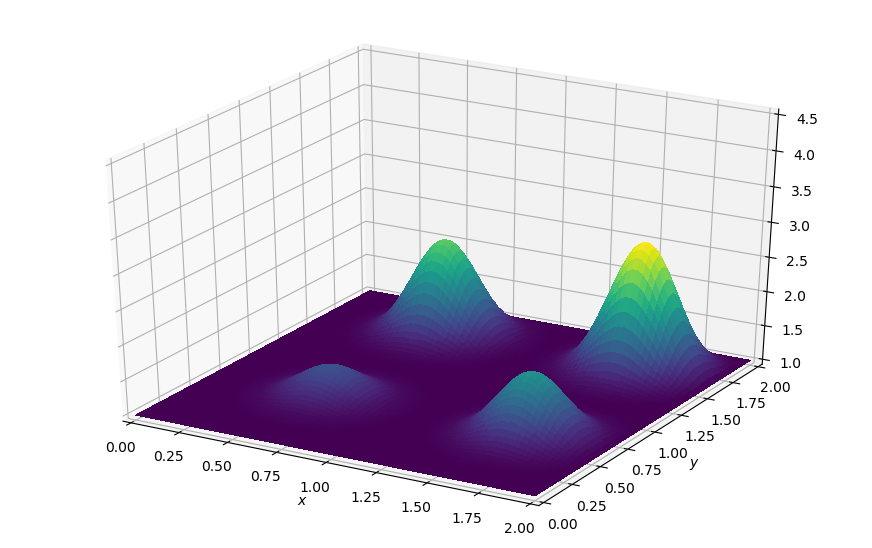

Operator `Kernel` run in 0.00 s


After another 50 timesteps


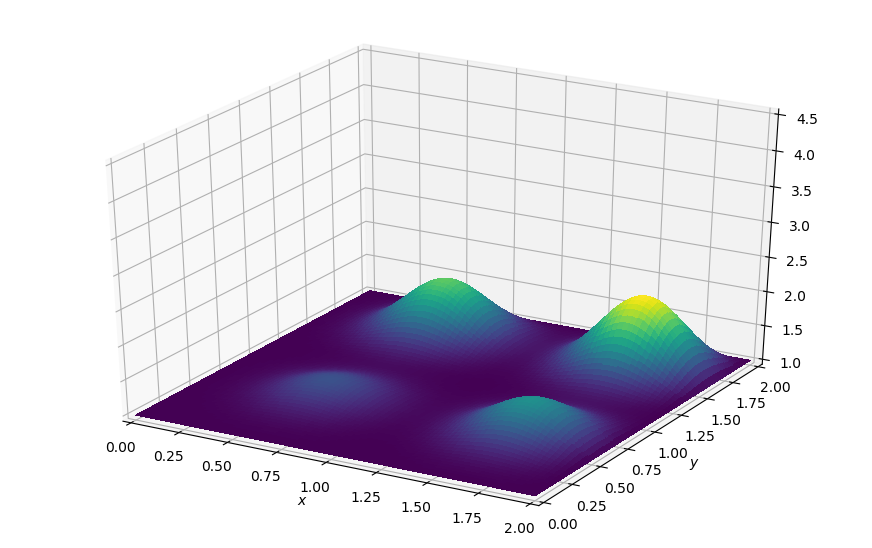

In [7]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator, Constant, Eq, solve

# Reset our data field and ICs
init_hat(field=u.data[0], dx=dx, dy=dy, value=1.)

# Field initialization
u.data[0][ nx//4:nx//4+10 , ny//4:ny//4+10 ] = 2
u.data[0][ 3*nx//4:3*nx//4+10 , ny//4:ny//4+10 ] = 3
u.data[0][ nx//4:nx//4+10 , 3*ny//4:3*ny//4+10 ] = 4
u.data[0][ 3*ny//4:3*ny//4+10 , 3*ny//4:3*ny//4+10 ] = 5


# Create an operator with second-order derivatives
a = Constant(name='a')
eq = Eq(u.dt, a * u.laplace, subdomain=grid.interior)
stencil = solve(eq, u.forward)
eq_stencil = Eq(u.forward, stencil)

# Create boundary condition expressions
x, y = grid.dimensions
t = grid.stepping_dim
bc = [Eq(u[t+1, 0, y], 1.)]  # left
bc += [Eq(u[t+1, nx-1, y], 1.)]  # right
bc += [Eq(u[t+1, x, ny-1], 1.)]  # top
bc += [Eq(u[t+1, x, 0], 1.)]  # bottom

op = Operator([eq_stencil] + bc)
op(time=nt, dt=dt, a=nu)

print ("After", nt, "timesteps")
plot_field(u.data[0], zmax=4.5)

op(time=nt, dt=dt, a=nu)
print ("After another", nt, "timesteps")
plot_field(u.data[0], zmax=4.5)

And now let's use the same operator again to show the more diffused field. In fact, instead of resetting the previously used object `u`, we can also create a new `TimeFunction` object and tell our operator to use this. In this cell we will double the value of `time`.

Operator `Kernel` run in 0.00 s


After 100 timesteps


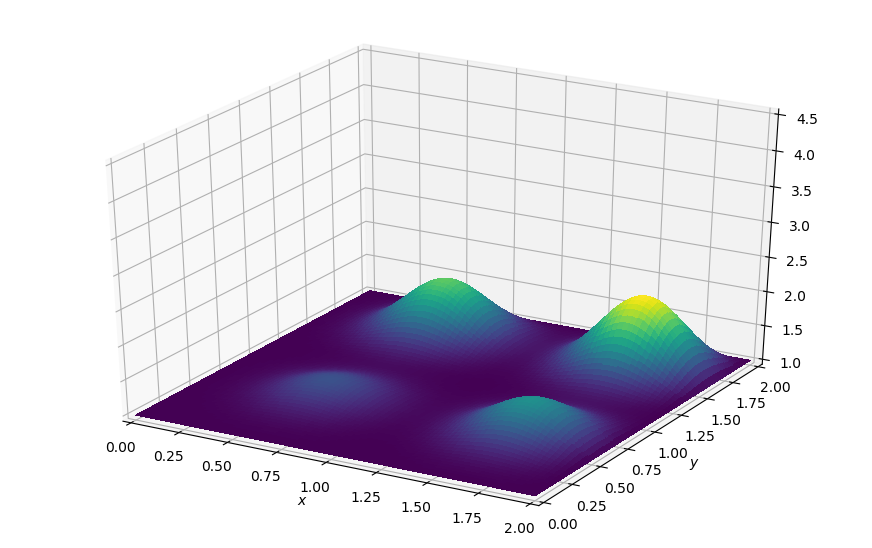

Operator `Kernel` run in 0.00 s


After another 100 timesteps


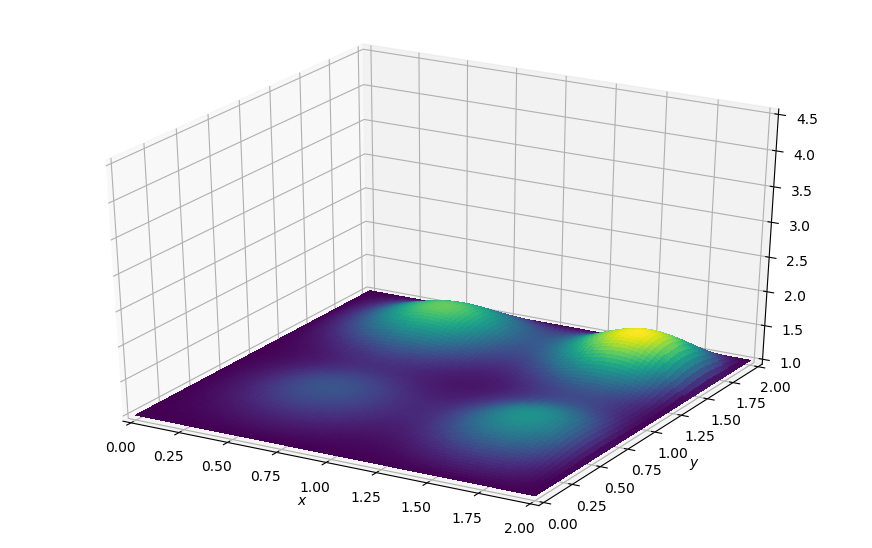

In [10]:
#NBVAL_IGNORE_OUTPUT
u2 = TimeFunction(name='u2', grid=grid, space_order=2)
init_hat(field=u2.data[0], dx=dx, dy=dy, value=1.)

# Field initialization
u2.data[0][ nx//4:nx//4+10 , ny//4:ny//4+10 ] = 2
u2.data[0][ 3*nx//4:3*nx//4+10 , ny//4:ny//4+10 ] = 3
u2.data[0][ nx//4:nx//4+10 , 3*ny//4:3*ny//4+10 ] = 4
u2.data[0][ 3*ny//4:3*ny//4+10 , 3*ny//4:3*ny//4+10 ] = 5

op(u=u2, time=2*nt, dt=dt, a=nu)


print ("After", 2*nt, "timesteps")
plot_field(u2.data[0], zmax=4.5)

op(u=u2, time=2*nt, dt=dt, a=nu)
print ("After another", 2*nt, "timesteps")
plot_field(u2.data[0], zmax=4.5)